In [1]:
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM

from common import read_from_hudi, write_to_hudi, create_spark_session
from config import get_selected_items_faostat

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [111]:
spark = create_spark_session("ForecastCropPrice")

In [ ]:
df_spark = spark.sql(f"""
    SELECT  ff.ProducerPrice_LCU_tonne_LCU_month,
            dd.YearMonth,
            ff.CropCode+
    FROM default.fact_faostat AS ff           
        JOIN default.dim_date  AS dd ON dd.DateINT = ff.DateINT
    WHERE ProducerPrice_LCU_tonne_LCU_month IS NOT NULL AND ProducerPrice_SLC_tonne_SLC_month IS NULL
    ORDER BY dd.YearMonth
""")


In [267]:
df_pandas = df_spark.toPandas()

missing_values = df_pandas.isnull().sum()
print(missing_values)

ProducerPrice_LCU_tonne_LCU_month    0
YearMonth                            0
CropCode                             0
dtype: int64


In [291]:
#crop_code = 27
crop_code = 687
#crop_name = df_crops[df_crops['CropCode'] == crop_code].first()['Crops']

df_true_crop = df_pandas[df_pandas['CropCode'] == crop_code] 

print(len(df_true_crop))

df_true_crop['date'] = pd.to_datetime(df_true_crop['YearMonth'], format='%Y%m')

df_time_series = df_true_crop[['ProducerPrice_LCU_tonne_LCU_month', 'YearMonth']]

# Chuẩn hóa giá trị để tăng độ ổn định
scaler = MinMaxScaler(feature_range=(0,1))
df_time_series['scaled_price'] = scaler.fit_transform(df_time_series[['ProducerPrice_LCU_tonne_LCU_month']])

# Chuyển dữ liệu thành dạng phù hợp với RNN/LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Xây dựng tập dữ liệu huấn luyện
seq_length = 12  # Dùng 10 ngày trước để dự đoán ngày tiếp theo
X, y = create_sequences(df_time_series['scaled_price'].values, seq_length)

# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Định dạng lại dữ liệu cho RNN/LSTM (batch_size, time_steps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

148


C:\Users\Acer\AppData\Local\Temp\ipykernel_1332\3813947503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_crop['date'] = pd.to_datetime(df_true_crop['YearMonth'], format='%Y%m')
C:\Users\Acer\AppData\Local\Temp\ipykernel_1332\3813947503.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series['scaled_price'] = scaler.fit_transform(df_time_series[['ProducerPrice_LCU_tonne_LCU_month']])


In [292]:
rnn_model = Sequential([
    SimpleRNN(units=60, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
    Dense(units=1)
])

rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
6/6 [==============================] - 8s 448ms/step - loss: 0.2266 - val_loss: 0.0536
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0862 - val_loss: 0.0026
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0415 - val_loss: 0.0024
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0244 - val_loss: 0.0022
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0199 - val_loss: 0.0027
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0019
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0021
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 11/50
6/6 [===========

In [ ]:
#lstm_model = Sequential([
#    LSTM(units=50, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
#    Dense(units=1)
#])
#lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=64, return_sequences=True))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mse')


lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose = 2)

Epoch 1/100
95/95 - 9s - loss: 0.0563 - 9s/epoch - 99ms/step
Epoch 2/100
95/95 - 1s - loss: 0.0376 - 873ms/epoch - 9ms/step
Epoch 3/100
95/95 - 1s - loss: 0.0220 - 876ms/epoch - 9ms/step
Epoch 4/100
95/95 - 1s - loss: 0.0166 - 998ms/epoch - 11ms/step
Epoch 5/100
95/95 - 1s - loss: 0.0154 - 933ms/epoch - 10ms/step
Epoch 6/100
95/95 - 1s - loss: 0.0082 - 896ms/epoch - 9ms/step
Epoch 7/100
95/95 - 1s - loss: 0.0065 - 912ms/epoch - 10ms/step
Epoch 8/100
95/95 - 1s - loss: 0.0065 - 914ms/epoch - 10ms/step
Epoch 9/100
95/95 - 1s - loss: 0.0051 - 1s/epoch - 14ms/step
Epoch 10/100
95/95 - 1s - loss: 0.0039 - 1s/epoch - 11ms/step
Epoch 11/100
95/95 - 1s - loss: 0.0039 - 1s/epoch - 12ms/step
Epoch 12/100
95/95 - 1s - loss: 0.0034 - 1s/epoch - 11ms/step
Epoch 13/100
95/95 - 1s - loss: 0.0048 - 890ms/epoch - 9ms/step
Epoch 14/100
95/95 - 1s - loss: 0.0031 - 868ms/epoch - 9ms/step
Epoch 15/100
95/95 - 1s - loss: 0.0033 - 923ms/epoch - 10ms/step
Epoch 16/100
95/95 - 1s - loss: 0.0032 - 903ms/epoch -

2/2 [==============================] - 0s 13ms/step


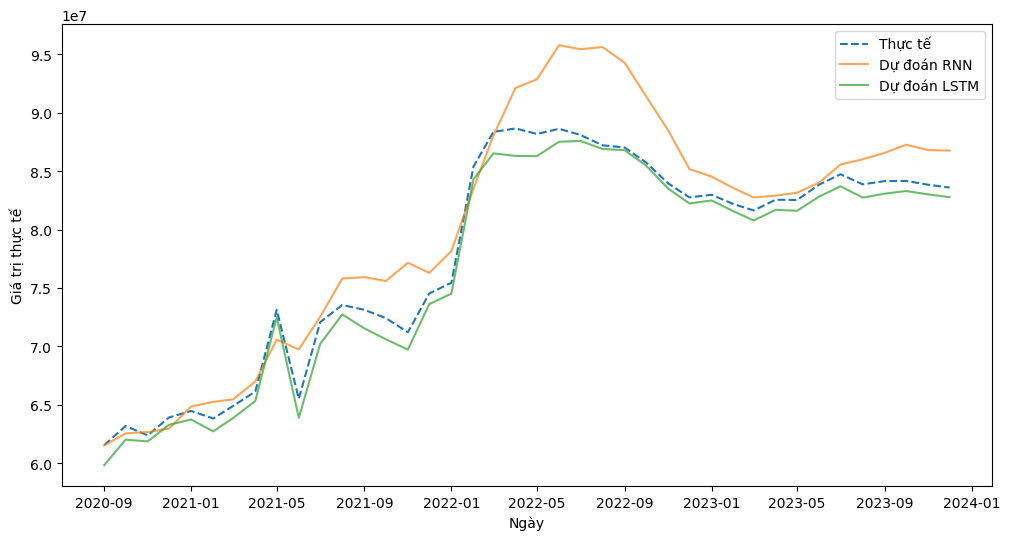

In [331]:
# Dự đoán bằng RNN
rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)  # Chuyển về đơn vị gốc

# Dự đoán bằng LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Chuyển về đơn vị gốc

# Chuyển y_test về giá trị gốc để so sánh
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions = rnn_predictions[1:]
lstm_predictions =lstm_predictions[1:]
y_test_original = y_test_original[:-1]

# Vẽ kết quả dự đoán
plt.figure(figsize=(12, 6))
#plt.plot(df_time_series['date'], df_time_series['ProducerPrice_LCU_tonne_LCU_month'], label="Thực tế", linestyle='dashed')
#plt.plot(df_time_series['date'].values[-len(y_test):], rnn_predictions, label="Dự đoán RNN", alpha=0.7)
#plt.plot(df_time_series['date'].values[-len(y_test):], lstm_predictions, label="Dự đoán LSTM", alpha=0.7)
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], y_test_original, label="Thực tế", linestyle='dashed')
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], rnn_predictions, label="Dự đoán RNN", alpha=0.7)
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], lstm_predictions, label="Dự đoán LSTM", alpha=0.7)
plt.xlabel("Ngày")
plt.ylabel("Giá trị thực tế")
plt.legend()
plt.show()


In [332]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Chuyển đổi giá trị dự đoán về đơn vị gốc
#rnn_predictions = scaler.inverse_transform(rnn_model.predict(X_test))
#lstm_predictions = scaler.inverse_transform(lstm_model.predict(X_test))
#y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính các chỉ số đánh giá cho RNN
rnn_mse = mean_squared_error(y_test_original, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(y_test_original, rnn_predictions)
rnn_r2 = r2_score(y_test_original, rnn_predictions)

# Tính các chỉ số đánh giá cho LSTM
lstm_mse = mean_squared_error(y_test_original, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_original, lstm_predictions)
lstm_r2 = r2_score(y_test_original, lstm_predictions)

# In kết quả
print(f"🔹 Hiệu suất mô hình RNN:")
print(f"  - MSE: {rnn_mse:.4f}")
print(f"  - RMSE: {rnn_rmse:.4f}")
print(f"  - MAE: {rnn_mae:.4f}")
print(f"  - R² Score: {rnn_r2:.4f}")

print(f"\n🔹 Hiệu suất mô hình LSTM:")
print(f"  - MSE: {lstm_mse:.4f}")
print(f"  - RMSE: {lstm_rmse:.4f}")
print(f"  - MAE: {lstm_mae:.4f}")
print(f"  - R² Score: {lstm_r2:.4f}")


🔹 Hiệu suất mô hình RNN:
  - MSE: 11692187582464.0000
  - RMSE: 3419384.0000
  - MAE: 2597676.7500
  - R² Score: 0.8542

🔹 Hiệu suất mô hình LSTM:
  - MSE: 1270664134656.0000
  - RMSE: 1127237.3750
  - MAE: 1011732.5000
  - R² Score: 0.9842


In [301]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict


def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)



def prepare_data_for_crop(df, crop_code, sequence_length=12, test_length=24):
    """
    Chuẩn bị dữ liệu cho một loại cây trồng cụ thể
    """
    # Lọc dữ liệu theo crop_code
    crop_data = df[df['CropCode'] == crop_code].copy()
 
    if len(crop_data) < sequence_length + 1:
        return None, None, None, None, None, None, None

    train_data = crop_data[:-test_length]
    test_data = crop_data[-(test_length + sequence_length):]


    if len(train_data) < sequence_length + 1:
        return None, None, None, None, None, None, None
    
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    scaled_train_data = scaler.fit_transform(train_data[['ProducerPrice_LCU_tonne_LCU_month']])
    scaled_test_data = scaler.transform(test_data[['ProducerPrice_LCU_tonne_LCU_month']])
    X_train, y_train = create_sequences(scaled_train_data)
    X_test, y_test = create_sequences(scaled_test_data)
    
    return X_train, X_test, y_train, y_test, scaler, train_data, test_data

def create_rnn_model(sequence_length):
    """
    Tạo mô hình RNN
    """
    model = Sequential([
        SimpleRNN(64, input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

def create_lstm_model(sequence_length):
    """
    Tạo mô hình LSTM
    """
    model = Sequential([
        LSTM(64, input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

def train_and_evaluate_models_for_crop(df, crop_code, sequence_length = 12, test_length = 24):
    """
    Huấn luyện và đánh giá mô hình cho một loại cây trồng
    """
    # Chuẩn bị dữ liệu
    X_train, X_test, y_train, y_test, scaler, train_data, test_data = prepare_data_for_crop(df, crop_code, sequence_length,test_length)
    
    if X_train is None:
        print(f"Không đủ dữ liệu cho loại cây trồng {crop_code}")
        return None, None, None, None, None
    
    # Tạo và huấn luyện mô hình RNN
    rnn_model = create_rnn_model(sequence_length)
    rnn_history = rnn_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1)
    
    # Tạo và huấn luyện mô hình LSTM
    lstm_model = create_lstm_model(sequence_length)
    lstm_history = lstm_model.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                validation_split=0.2,
                                verbose=1)
    # Đánh giá mô hình
    rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
    lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)


    print(f"\nKết quả cho loại cây trồng {crop_code}:")
    print(f"RNN Model - Test Loss: {rnn_loss:.4f}, Test MAE: {rnn_mae:.4f}")
    print(f"LSTM Model - Test Loss: {lstm_loss:.4f}, Test MAE: {lstm_mae:.4f}")
    
    # Vẽ đồ thị so sánh
    plt.figure(figsize=(12, 6))
    plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
    plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
    plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
    plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
    plt.title(f'Model Loss Comparison for Crop Code {crop_code}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return rnn_model, lstm_model, scaler, train_data, test_data

def predict_test_period(model, test_data, scaler, sequence_length=12):
    """
    Dự đoán giá cho giai đoạn test
    """
    scaled_test_data = scaler.transform(test_data[['ProducerPrice_LCU_tonne_LCU_month']])
    predictions = []
    
    for i in range(len(scaled_test_data) - sequence_length):
        sequence = scaled_test_data[i:(i + sequence_length)]
        pred = model.predict(sequence.reshape(1, sequence_length, 1))
        predictions.append(pred[0])
    
    predictions = scaler.inverse_transform(np.array(predictions))
    actual_values = test_data['ProducerPrice_LCU_tonne_LCU_month'].values[sequence_length:]
    dates = test_data['YearMonth'].values[sequence_length:]
    
    return predictions, actual_values, dates

def plot_predictions_vs_actual(crop_code, dates, actual_values, rnn_predictions, lstm_predictions):
    """
    Vẽ biểu đồ so sánh dự đoán với giá trị thực tế
    """
    plt.figure(figsize=(15, 7))
    
    # Chuyển đổi dates thành datetime nếu chưa phải
    if not pd.api.types.is_datetime64_any_dtype(dates):
        dates = pd.to_datetime(dates)
    
    # Vẽ dữ liệu thực tế
    plt.plot(dates, actual_values, label='Actual Values', color='blue', alpha=0.7)
    
    # Vẽ dự đoán RNN
    plt.plot(dates, rnn_predictions, label='RNN Predictions', color='red', linestyle='--')
    
    # Vẽ dự đoán LSTM
    plt.plot(dates, lstm_predictions, label='LSTM Predictions', color='green', linestyle='--')
    
    # Định dạng biểu đồ
    plt.title(f'Price Predictions vs Actual Values for Crop Code {crop_code}')
    plt.xlabel('Date')
    plt.ylabel('Price (LCU/tonne)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Xoay nhãn trục x để dễ đọc
    plt.xticks(rotation=45)
    
    # Điều chỉnh layout để tránh cắt nhãn
    plt.tight_layout()

    # Hiển thị biểu đồ
    plt.show()

    rnn_r2 = r2_score(actual_values, rnn_predictions)
    lstm_r2 = r2_score(actual_values, lstm_predictions)

    print(f"RNN Model - Test R2: {rnn_r2:.4f}")
    print(f"LSTM Model - Test R2: {lstm_r2:.4f}")

def train_and_predict_all_crops(df, crop_codes=None, sequence_length=12, test_length=24):
    """
    Huấn luyện và dự đoán cho các loại cây trồng được chỉ định    
    """
    df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y%m')

    crop_models = defaultdict(dict)
    crop_predictions = defaultdict(dict)
    
    # Nếu không có danh sách crop_codes, lấy tất cả các loại cây
    if crop_codes is None:
        crop_codes = df['CropCode'].unique()
    else:
        # Kiểm tra xem các crop_code có tồn tại trong dữ liệu không
        existing_codes = df['CropCode'].unique()
        invalid_codes = [code for code in crop_codes if code not in existing_codes]
        if invalid_codes:
            print(f"Cảnh báo: Các mã cây trồng sau không tồn tại trong dữ liệu: {invalid_codes}")
            crop_codes = [code for code in crop_codes if code in existing_codes]
            if not crop_codes:
                print("Không có mã cây trồng hợp lệ để dự đoán.")
                return crop_models, crop_predictions
    
    print(f"\nBắt đầu dự đoán cho {len(crop_codes)} loại cây trồng:")
    
    for crop_code in crop_codes:
        print(f"\nXử lý loại cây trồng: {crop_code}")
        
        # Huấn luyện mô hình
        rnn_model, lstm_model, scaler, train_data, test_data = train_and_evaluate_models_for_crop(df, crop_code, sequence_length, test_length)
        
        if rnn_model is not None:
            # Lưu mô hình
            crop_models[crop_code] = {
                'rnn': rnn_model,
                'lstm': lstm_model,
                'scaler': scaler
            }

            # Lấy dữ liệu lịch sử cho loại cây này
            historical_data = df[df['CropCode'] == crop_code].sort_values('YearMonth')
            
            # Dự đoán cho giai đoạn test
            rnn_predictions, actual_values, dates = predict_test_period(rnn_model, test_data, scaler, sequence_length)
            lstm_predictions, _, _ = predict_test_period(lstm_model, test_data, scaler, sequence_length)
            
            crop_predictions[crop_code] = {
                'rnn': rnn_predictions,
                'lstm': lstm_predictions,
                'actual': actual_values,
                'dates': dates
            }
             # Vẽ biểu đồ so sánh
            plot_predictions_vs_actual(crop_code, dates, actual_values, rnn_predictions, lstm_predictions)
            
    
    return crop_models, crop_predictions




Bắt đầu dự đoán cho 1 loại cây trồng:

Xử lý loại cây trồng: 687
Epoch 1/50
3/3 [==============================] - 6s 355ms/step - loss: 0.5942 - mae: 0.6621 - val_loss: 0.0107 - val_mae: 0.1023
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 0.2057 - mae: 0.3642 - val_loss: 0.0373 - val_mae: 0.1925
Epoch 3/50
3/3 [==============================] - 0s 36ms/step - loss: 0.1301 - mae: 0.2815 - val_loss: 0.0818 - val_mae: 0.2833
Epoch 4/50
3/3 [==============================] - 0s 33ms/step - loss: 0.0945 - mae: 0.2509 - val_loss: 0.0900 - val_mae: 0.2945
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0810 - mae: 0.2058 - val_loss: 0.0478 - val_mae: 0.2132
Epoch 6/50
3/3 [==============================] - 0s 31ms/step - loss: 0.0651 - mae: 0.2084 - val_loss: 0.0108 - val_mae: 0.1012
Epoch 7/50
3/3 [==============================] - 0s 36ms/step - loss: 0.0608 - mae: 0.1979 - val_loss: 0.0026 - val_mae: 0.0487
Epoch 8/50
3/3 [==============

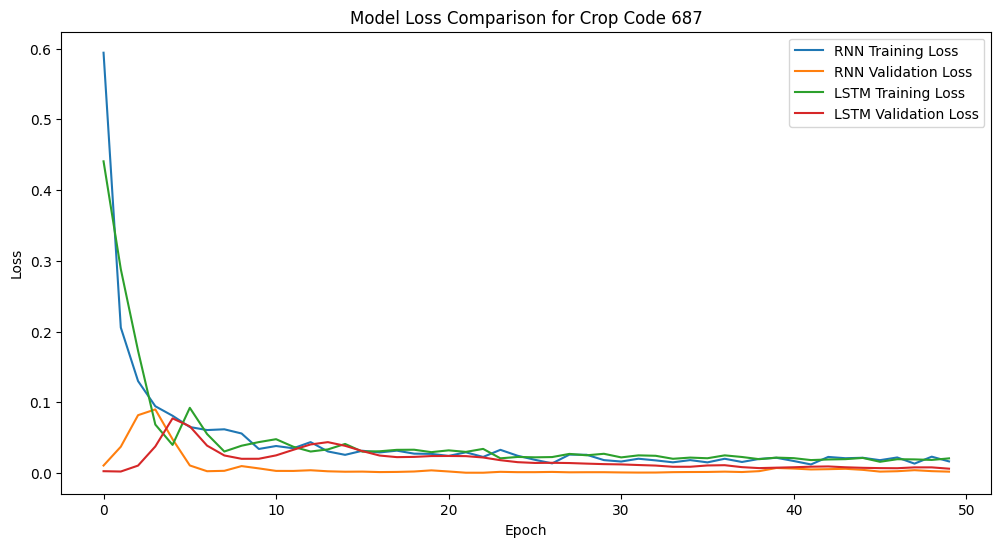

1/1 [==============================] - 0s 26ms/step


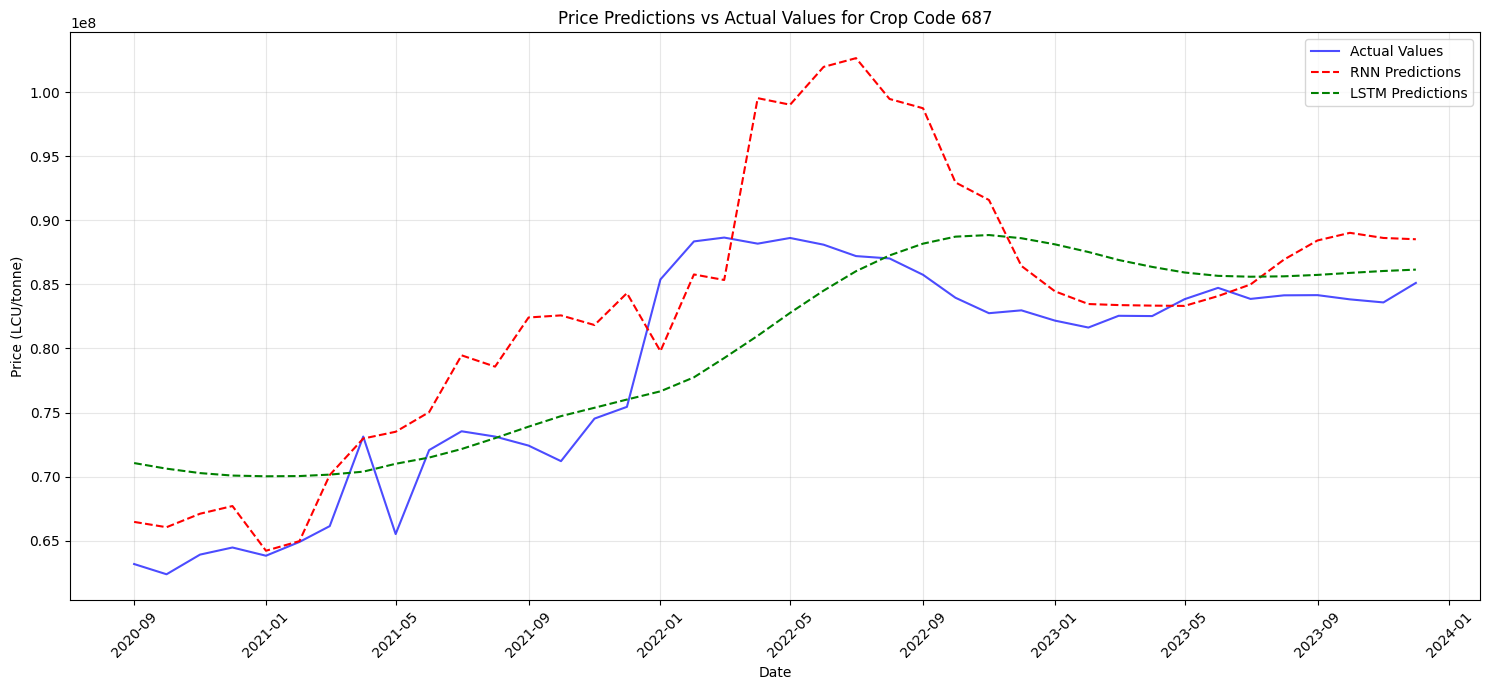

RNN Model - Test R2: 0.3721
LSTM Model - Test R2: 0.6845


In [303]:
df_pandas3 = df_pandas.copy()
# Huấn luyện và dự đoán cho tất cả các loại cây trồng
crop_models, crop_predictions = train_and_predict_all_crops(df_pandas3, [687], test_length = 40)



In [ ]:
# Lưu kết quả dự đoán vào file
results = []
for crop_code, predictions in crop_predictions.items():
    for month in range(12):
        results.append({
            'CropCode': crop_code,
            'Month': month + 1,
            'RNN_Prediction': predictions['rnn'][month][0],
            'LSTM_Prediction': predictions['lstm'][month][0]
        })

results_df = pd.DataFrame(results)
results_df.to_csv('crop_price_predictions.csv', index=False)
print("\nKết quả dự đoán đã được lưu vào file 'crop_price_predictions.csv'")

In [333]:
spark.stop()